# Personal Information
Name: **Patrick Spaargaren**

StudentID: **13502573**

Email: [**patrick.spaargaren@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **22.03.2024**

In this EDA section, I will introduce the datasets that I intend to use for my thesis.

Odeuropa data: This dataset was created by the research institute Odeuropa, which I obtained through my institutional supervisor Marieke van Erp, but is also publicly available via this website https://odeuropa.eu/. The dataset consists of sentences filtered from various corpora based on their description of a scent. From this data, I will use the (lemmatized) scent source along with the associated sentences to perform sentiment analysis. The data is available in different languages, but for the EDA and considering the scope of the thesis, I will only use the English and possibly the Dutch dataset.

Validation data: I am still in the process of finding data to validate the model. Data from previous smellwalk-based research is available; however, this data is not yet publicly accessible. The data has been requested. It will consist of locations accompanied by a scent description, including associated sentiment. The aim of the thesis is to develop a model, based on the techniques described in the thesis design, that predicts the scent at specific geographic locations using geographic data and Odeuropa data.

Geographic data: The geographic data utilizes the geographical maps of maps.amsterdam.nl to combine natural sources with Odeuropa data, and Google Maps data to incorporate scents from specific shops and restaurants.

github link: https://github.com/patrickuva/thesis_spaargaren_smellmaps

# Data Description

For the thesis, data from different sources will be combined to build a model that can predict scents at specific locations. The Exploratory Data Analysis (EDA) will delve further into the scent data, on which sentiment analysis will be conducted. The image below provides an overview of how the sources will be merged to achieve this. The map data and the object description data will be used to calculate 2 target variables: the observable smell and its sentiment on a specific geographical location.

(![example.png](<Screenshot 2024-03-19 at 21.27.01.png>))

In [1]:
#imports
import pandas as pd
import ipywidgets as widgets
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools

/Users/patrickjonathan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Data Loading

In [2]:
en_data = pd.read_csv('Dataset_en.tsv', sep='\t')
#The structure of the NL data is similar to the one of the EN data, but since
#the EN data seems good enough, we will focus on this data in the EDA.
nl_data = pd.read_csv('Dataset_nl.tsv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset_nl.tsv'

### Analysis 1: Missing values and feature description
The first analysis focuses on the structure of the data, the feature descriptions, and some notable aspects. The data contains the following features:

Feature descriptions:
- Lang: language, string
- Year: year of writing of the sentence (1400 - 1920), integer
- Smell source lemma: the source extracted from the sentence, string
- Sentence lemma: lemmatized version of the sentence, string
- Corpus: the corpus the sentence came from, string
- Smell_source: the source extracted from the sentence, string
- Quality: 
- Sentence: the sentence that is about smell, string

The data comprises 1,360,693 rows. The following plot illustrates the number of missing values in the data.

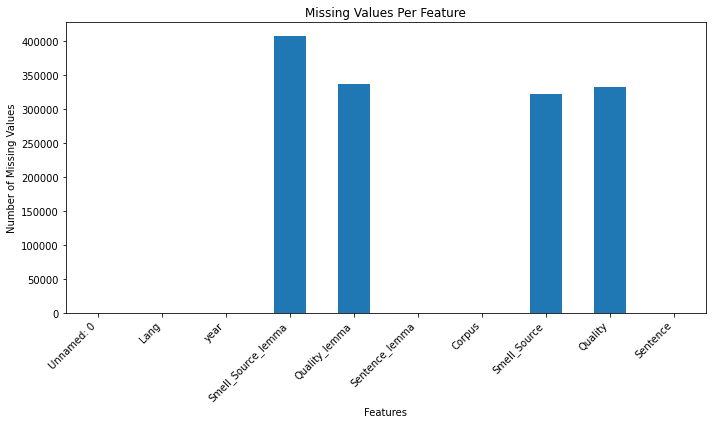

In [ ]:
# Plotting missing values per column
missing_values = en_data.isnull().sum()
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar')
plt.title('Missing Values Per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Both the Quality_Lemma and Quality columns, as well as the Smell_Source column, contain 300,000 missing values each. However, this indicates that more than a million rows are complete, and since we won't directly use the Quality column, the missing values at first glance should not pose a problem.

### Analysis 2: Distribution over the Years

The collected sentences span a period of approximately 500 years (1500 - 2000). The time at which the descriptions were made could potentially influence the results of the sentiment analysis and thereby affect the model's outcomes. For this reason, Analysis 2 examines the years in which the sentences were written.


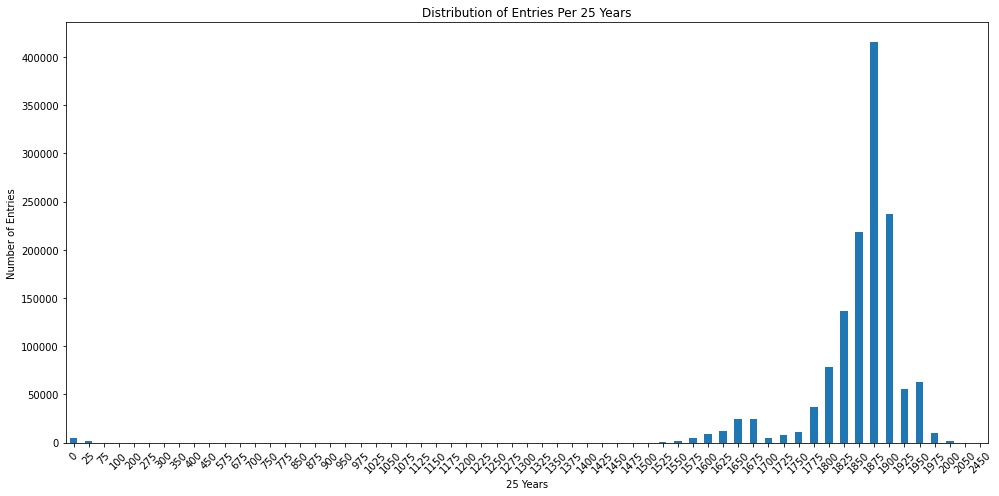

In [ ]:
# For Distribution of Entries Per 25 Years
en_data['decade'] = (en_data['year'] // 25) * 25
decade_distribution = en_data['decade'].value_counts().sort_index()
plt.figure(figsize=(14, 7))
decade_distribution.plot(kind='bar')
plt.title('Distribution of Entries Per 25 Years')
plt.xlabel('25 Years')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The sentences primarily originate from the 18th to the 20th century, with high peaks from the 19th century. This should be taken into account in sentiment analysis, as many methods, including VADER, are specifically developed for sentiment analysis on more modern texts. What is also noticeable is that there are some outliers from the years 0 and 25. These still need to be removed.

### Analysis 3, Corpus Distribution

The data contains texts from various corpora. A corpus may employ a specific writing style, potentially biasing any results. For this reason, it has been chosen to examine whether the texts within the corpora are evenly distributed.

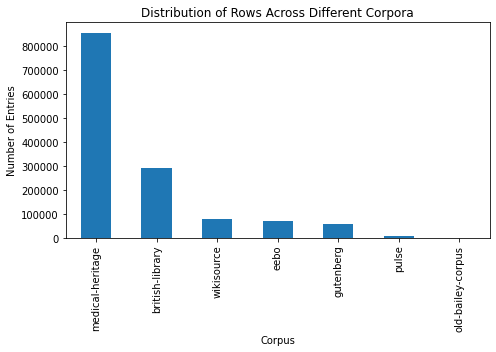

Corpus
medical-heritage     856603
british-library      289969
wikisource            80539
eebo                  69112
gutenberg             58438
pulse                  5792
old-bailey-corpus       240
Name: count, dtype: int64


In [ ]:
corpus_distribution = en_data['Corpus'].value_counts()

# Plotted distribution of rows across different corpora
plt.figure(figsize=(7, 5))
corpus_distribution.plot(kind='bar')
plt.title('Distribution of Rows Across Different Corpora')
plt.xlabel('Corpus')
plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()

# Printed Distribution
print(corpus_distribution)

Analysis 3 reveals that most sentences originate from a single corpus. This could indicate a focus on specific sources. The next analysis will determine if the number of sources remains sufficiently large.

### Analysis 4: Source fequency

The lemmatized source column will ultimately be one of the most important features for the research. It is crucial that there are enough different sources and that they are generally mentioned frequently. For this reason, I initially examined the frequency.

Average number of parts separated by '|': 1.666390581857921


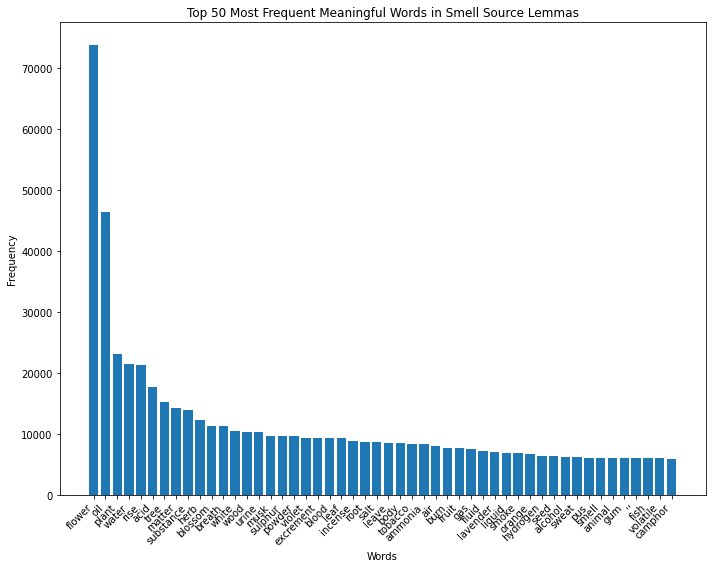

In [ ]:
# Replacing NaN with an empty string
en_data['Smell_Source_lemma'] = en_data['Smell_Source_lemma'].fillna('')

# Calculate the average number of parts (words or phrases) separated by "|"
en_data['smell_source_parts'] = en_data['Smell_Source_lemma'].str.split('|').apply(len)
average_parts = en_data['smell_source_parts'].mean()
print(f"Average number of parts separated by '|': {average_parts}")

# Prepare for word frequency distribution analysis
# Splitting 'Smell_Source_lemma' into words considering "|" as a separator
words_list = en_data['Smell_Source_lemma'].str.replace('|', ' ', regex=False).str.lower().str.split()

# Flatten the lists into a single list containing all words
all_words_flat = list(itertools.chain(*words_list))

# Count the occurrences of each word using Counter
word_frequencies = Counter(all_words_flat)

# Making a dataframe from the word counts
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)


# Filter out non-existing words by removing words with less than 2 characters,
# I can include stopwords later
filtered_word_freq_df = word_freq_df[word_freq_df['Word'].str.len() > 1]



# Take top 50 filtered words
top_50_filtered_words = filtered_word_freq_df.head(50)

# Plotting most frequent words
plt.figure(figsize=(10, 8))
plt.bar(top_50_filtered_words['Word'], top_50_filtered_words['Frequency'])
plt.title('Top 50 Most Frequent Meaningful Words in Smell Source Lemmas')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It is noteworthy that there is a large amount of data available for a wide variety of sources. However, not all sources will be relevant for describing the scent in cities. Because of this, further filtering is needed.

### Analysis 5: Sentiment analysis on most frequent words

Finally I performed VADER analysis on the most frequent words, by using the sentences. This model takes long to run, because of this, I will provide the code and will use the csv, earlier created by the code, to make the final plots.

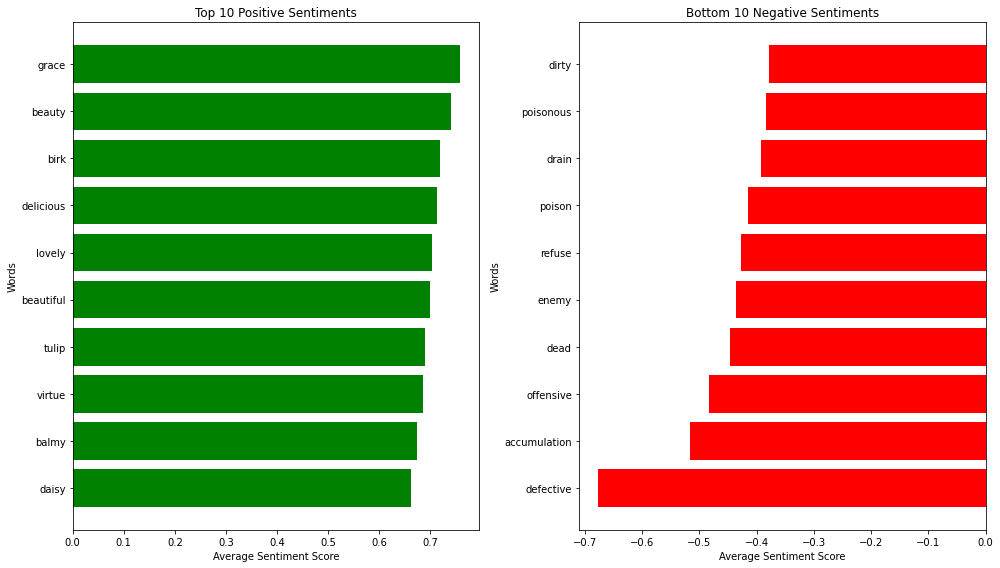

In [ ]:
'''from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

# Initialize the VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a set of unique words for efficient lookup
unique_words = set(word_freq_filter['Word'])

# Preprocess 'en_data' to include a boolean flag indicating if the row's 'Smell_Source_lemma' contains any of the unique words
en_data['relevant_for_analysis'] = en_data['Smell_Source_lemma'].apply(lambda x: any(word in x for word in unique_words))

# Function to calculate the average sentiment for sentences related to a specific word
def analyze_sentiment_for_word(word):
    relevant_sentences = en_data[(en_data['relevant_for_analysis']) & (en_data['Smell_Source_lemma'].str.contains(word, case=False, regex=False))]['Sentence']
    if len(relevant_sentences) > 0:
        scores = relevant_sentences.apply(lambda sentence: analyzer.polarity_scores(sentence)['compound'])
        return scores.mean()
    return None

# Analyze sentiment for each word, storing results in a dictionary
sentiment_scores = {}
for word in tqdm(unique_words, desc="Analyzing Sentiment"):
    average_score = analyze_sentiment_for_word(word)
    if average_score is not None:
        sentiment_scores[word] = average_score

# Convert the sentiment_scores dictionary to a DataFrame for better visualization and analysis
sentiment_scores_df = pd.DataFrame(list(sentiment_scores.items()), columns=['Word', 'Average Sentiment Score']).sort_values(by='Average Sentiment Score', ascending=False)

#sentiment_scores_df.to_csv('first_draft_sentiment.csv')'''

# Read CSV that took 1 hour to make, by running the code above
sentiment_scores_df = pd.read_csv('first_draft_sentiment.csv')

# Sort the sentiment scores in a new sorted dataframe
sentiment_scores_df_sorted = sentiment_scores_df.sort_values(by='Average Sentiment Score')

# Select the highest and lowest 10 sentiment scores
top_10 = sentiment_scores_df_sorted.tail(10)
bottom_10 = sentiment_scores_df_sorted.head(10)

# Plotting both top 10 and bottom 10 in a single figure for comparison
plt.figure(figsize=(14, 8))

# Top 10 positive sentiments
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.barh(top_10['Word'], top_10['Average Sentiment Score'], color='green')
plt.title('Top 10 Positive Sentiments')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Words')

# Bottom 10 negative sentiments
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.barh(bottom_10['Word'], bottom_10['Average Sentiment Score'], color='red')
plt.title('Bottom 10 Negative Sentiments')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

At first glance, the sentiment analysis appears to be effective. Sources that I perceive as positive are also classified as positive based on the sentences, and vice versa. However, there are still many parameters that can be adjusted based on the scores of the final model.